In [5]:
# import libraries
import torch
from torch import nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# set seed
seed = 25

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [7]:
# load cifar10 dataset
from torchvision import datasets, transforms

save_dir = 'cifar10'

transform = transforms.ToTensor()

train_set = datasets.CIFAR10(save_dir, download=True, train=True, transform=transform)
test_set = datasets.CIFAR10(save_dir, download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10
    Split: Test
    StandardTransform
Transform: ToTensor()


In [8]:
# randomly create training and validation sets

from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 50000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size)

In [9]:
# CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
# train model
from tqdm.notebook import tqdm

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=1000):
    train_losses = []
    val_losses = []
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            train_losses.append(total_loss/count)
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
                val_losses.append(total_loss/count)
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return train_losses, val_losses

def test_network(model, test_loader, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

c:\Users\jonathan\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0
Exiting from training early
<torch.utils.data.dataloader.DataLoader object at 0x0000019E71783550> accuracy: 42.880


(42.88,
 array([3, 8, 8, ..., 5, 1, 7], dtype=int64),
 array([3, 1, 8, ..., 5, 7, 7], dtype=int64))

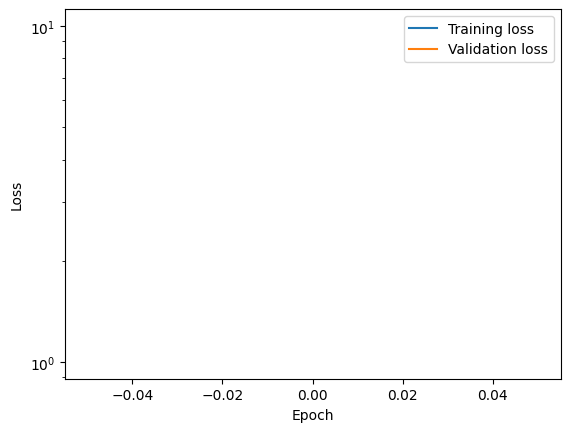

In [11]:
cnn = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)

train_losses, val_losses = train_network(cnn, train_loader, val_loader, criterion, optimizer)
plt.semilogy(train_losses, label="Training loss")
plt.semilogy(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

cnn.eval()

test_network(cnn, test_loader, train_loader)

In [12]:
# data augmentation
import torchvision
from torchvision import datasets, transforms

save_dir = 'cifar10'

transform = transforms.Compose([
                      transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.ColorJitter(hue=.05, saturation=.05),
                      transforms.RandomRotation([-180,180]),
                      transforms.ToTensor()
                  ])
train_set = datasets.CIFAR10(save_dir, download=True, train=True, transform=transform)
test_set = datasets.CIFAR10(save_dir, download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ColorJitter(brightness=None, contrast=None, saturation=[0.95, 1.05], hue=[-0.05, 0.05])
               RandomRotation(degrees=[-180.0, 180.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ColorJitter(brightness=None, contrast=None, saturation=[0.95, 1.05], hue=[-0.05, 0.05])
               RandomRotation(degrees=[-180.0, 180.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )


In [13]:
# as before
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 50000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size)

In [14]:
# regularized model
class CNNRegularized(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Dropout2d(0.4),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.layers(x)

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0
Exiting from training early
<torch.utils.data.dataloader.DataLoader object at 0x0000019E72B3EFA0> accuracy: 13.080


(13.08,
 array([3, 8, 8, ..., 5, 1, 7], dtype=int64),
 array([4, 8, 4, ..., 4, 4, 4], dtype=int64))

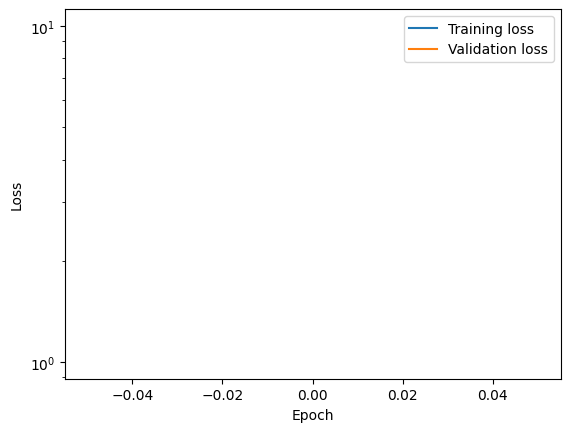

In [15]:
cnn_regularized = CNNRegularized()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_regularized.parameters(), lr=0.001)

reg_train_losses, reg_val_losses = train_network(cnn_regularized, train_loader, val_loader, criterion, optimizer)
plt.semilogy(reg_train_losses, label="Training loss")
plt.semilogy(reg_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

cnn_regularized.eval()

test_network(cnn_regularized, test_loader, train_loader)

In [16]:
# CNN transformer hybrid architecture
class CNNTransformer(nn.Module):
    def __init__(self):
        super(CNNTransformer, self).__init__()
        
        # CNN layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Dropout2d(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Dropout2d(0.3),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Dropout2d(0.4),
            nn.Flatten(),
            nn.LazyLinear(128),
        )
        
        # transformer layers
        self.embedding = nn.LazyLinear(512)
        self.transformer_encoder_layer = TransformerEncoderLayer(d_model=512, nhead=16)
        self.transformer_encoder = TransformerEncoder(self.transformer_encoder_layer, num_layers=3)
        self.dropout = nn.Dropout(p=0.2)
        
        self.fc = nn.LazyLinear(10)
    
    def forward(self, x):
        # CNN forward pass
        cnn_out = self.cnn_layers(x)
        cnn_out = cnn_out.view(cnn_out.size(0), -1)
        
        # transformer forward pass
        transformer_out = self.embedding(cnn_out)
        transformer_out = transformer_out.unsqueeze(0)
        transformer_out = self.transformer_encoder(transformer_out)
        transformer_out = transformer_out.squeeze()
        transformer_out = self.dropout(transformer_out)
        
        out = self.fc(transformer_out)
        return out

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0
Exiting from training early
<torch.utils.data.dataloader.DataLoader object at 0x0000019E72B3EFA0> accuracy: 15.540


(15.54,
 array([3, 8, 8, ..., 5, 1, 7], dtype=int64),
 array([2, 0, 8, ..., 2, 2, 2], dtype=int64))

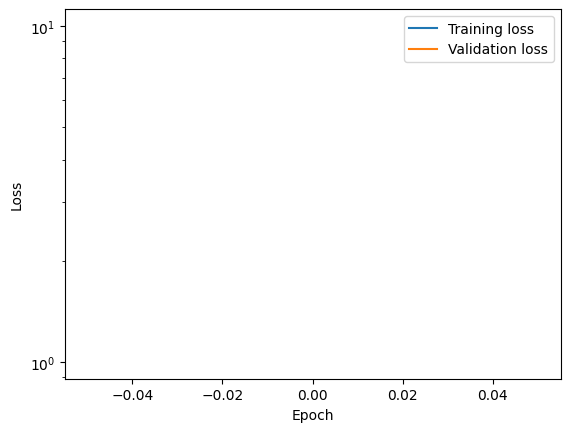

In [17]:
cnn_transformer = CNNTransformer()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_transformer.parameters(), lr=0.0005)

trans_train_losses, trans_val_losses = train_network(cnn_transformer, train_loader, val_loader, criterion, optimizer)
plt.semilogy(trans_train_losses, label="Training loss")
plt.semilogy(trans_val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

cnn_transformer.eval()

test_network(cnn_transformer, test_loader, train_loader)